## Gaussian Processes
---
#### Sean McLaughlin
##### DESC Hack Week April 2017

##### What is a GP?

A Gaussian Process (GP) is equal parts elegant statistical construct and  supervised machine learning algorithm. 
Its power comes from its ability to be interpreted in a myriad of ways.

* I use GP's for emulation. GPs allow me to perform smooth and "non-parametric" (LOL) emulation. The GP also produces well-defined statistical uncertainties, which is rare in machine learning. 

* Dan Foreman Mackey uses GPs as part of a larger inference to model correlated errors.

* Boris Leistedt uses GPs to extrapolate beyond the training data regime. 

These different interpretations of GPs arise from the same math, just a different perspective

##### What is a GP? | I know math.

A GP is a *collection of random variables, any finite number of which have a joint Gaussian distribution.*

In other words a function of a vector **x** is drawn from an *N* dimensional GP, where *N* is the length of **x**.

$$m(\mathbf{x}) = \mathop{{}\mathbb{E}}[f(\mathbf{x})] $$
$$k(\mathbf{x},\mathbf{x}^\intercal ) = \mathop{{}\mathbb{E}}[(f(\mathbf{x}) - m(\mathbf{x}) )(f(\mathbf{x^\intercal}) - m(\mathbf{x^\intercal}) )] $$

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x^\intercal})) $$

In general, we can assume $m(\mathbf{x}) = \vec{0}$ (and add it back in later if we want).

Then, our entire GP is determined by the kernel $k$. The kernel is a function that essentially answers the question "How correlated are two points $x_1$ and $x_2$. Kernels can be dependent on a particular point in space, osciallte, or do lots of crazy stuff (so long as they always produce a PSD covariance matrix). However, the most common one (and one we'll focus on) is a Gaussian kernel. 

In [ ]:
from IPython.display import Image
Image("./xibit.jpg")

$$k(x_1, x_2) = \exp\left(\frac{-|x_1-x_2|^2}{ l}\right) $$

The correlation between two points is only dependent on their distance, and it falls off with scale length $l$. We evaluate the kernel at each pair of dependent variables to get the covariance matrix.

$$k(x_1, x_2) = K_{1,2}$$

We can sample functions from this sort of unconstrainted GP.

In [2]:
import numpy as np
import george
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

/u/ki/swmclau2/.local/lib/python2.7/site-packages/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


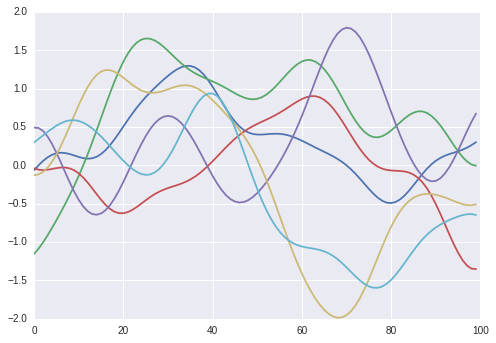

In [3]:
kernel = george.kernels.ExpSquaredKernel(1.0)
gp = george.GP(kernel)

t = gp.sample(np.linspace(0,10,100), 6)
for f in t:
    plt.plot(f)

Changing the scale length changes how "wiggly" it is.

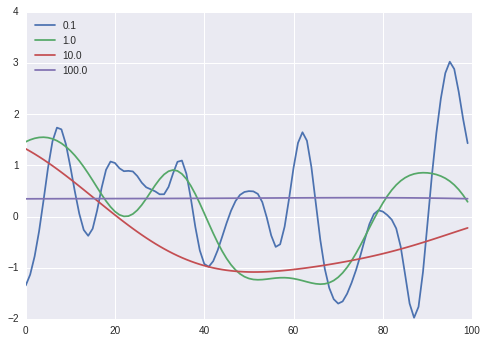

In [4]:
for l in [0.1, 1.0, 10.0, 100.0]:
    kernel = george.kernels.ExpSquaredKernel(l)
    gp = george.GP(kernel) 
    
    plt.plot(gp.sample(np.linspace(0,10,100)), label = l)
    
plt.legend(loc = 'best')
plt.show()

##### How do I make predictions? 

Predictions are made by drawing from the conditional distribution! We measure values of $\mathbf{x}$ and $f(\mathbf{x})$. Then, we can draw samples from the conditional distribution (which is a conditional Normal) at values were interested in, $\mathbf{x_*}$. Skipping the derivation:


$$\mathop{{}\mathbb{E}}[f(\mathbf{x_*}) | \mathbf{x_*}, \mathbf{x}, f(\mathbf{x})] = K(\mathbf{x_*}, \mathbf{x}) K^{-1}(\mathbf{x}, \mathbf{x}) f(\mathbf{x}) $$


$$\mathrm{\mathbb{Var}}[f(\mathbf{x_*}) | \mathbf{x_*}, \mathbf{x}, f(\mathbf{x})] = K(\mathbf{x_*},\mathbf{x_*}) - K(\mathbf{x_*}, \mathbf{x}) K^{-1}(\mathbf{x}, \mathbf{x}))K(\mathbf{x}, \mathbf{x_*})  $$

Let's add some data to our above plot. 

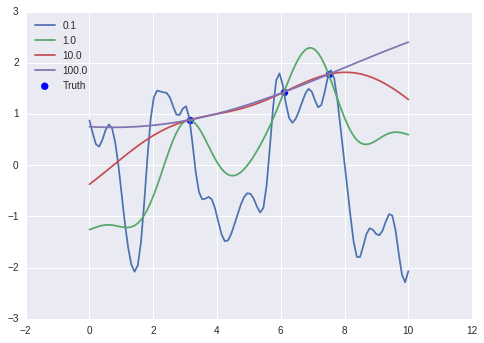

In [5]:
x = np.array([3.14, 6.1, 7.5])
yerr = 0.1
m, b = 0.2, -0.3
y = m*x-b + np.random.randn(x.shape[0])*yerr
plt.scatter(x,y, s = 50, color = 'b', label = 'Truth')

for l in [0.1, 1.0, 10.0, 100.0]:
    kernel = george.kernels.ExpSquaredKernel(l)
    gp = george.GP(kernel) 
    gp.compute(x)
    
    plt.plot(np.linspace(0,10,100), gp.sample_conditional(y, np.linspace(0,10,100)), label = l)
    
plt.legend(loc = 'best')

plt.show()

These are samples, but we can view the conditional distribution.

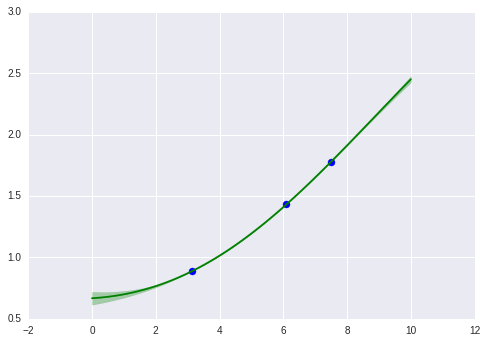

In [6]:
l = 10.0
mu, cov = gp.predict(y,np.linspace(0,10,100) )
err = np.sqrt(np.diag(cov))

plt.scatter(x,y, s = 50, color = 'b', label = 'Truth')

plt.plot(np.linspace(0,10,100), mu, color = 'g')
plt.fill_between(np.linspace(0,10,100), mu, mu+err, color = 'g', alpha = 0.3)
plt.fill_between(np.linspace(0,10,100), mu, mu-err, color = 'g', alpha = 0.3)

plt.show()

We can also add measurement errors to our data points.

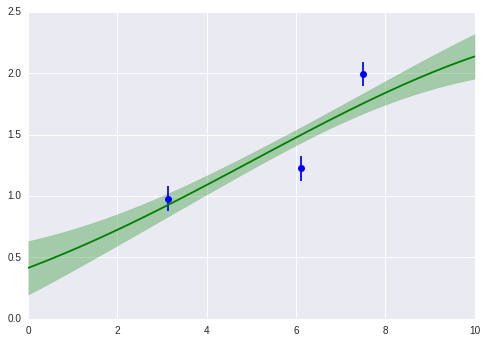

In [7]:
me  = 0.1
measurement_err = np.random.randn(x.shape[0])*me
gp.compute(x, me)
mu, cov = gp.predict(y+measurement_err,np.linspace(0,10,100) )
err = np.sqrt(np.diag(cov))

plt.errorbar(x,y+measurement_err,yerr = np.array([me for i in xrange(x.shape[0])]),fmt= 'o', color = 'b', label = 'Truth')

plt.plot(np.linspace(0,10,100), mu, color = 'g')
plt.fill_between(np.linspace(0,10,100), mu, mu+err, color = 'g', alpha = 0.3)
plt.fill_between(np.linspace(0,10,100), mu, mu-err, color = 'g', alpha = 0.3)

plt.show()

##### What's the catch?

Notice that in the prediction step, we have to invert the kernel matrix. Considering the kernel matrix has sidelength the same as the number of training points, building a GP is $\mathcal{O}(N^3)$ in time and $\mathcal{O}(N^2)$ in space. This can be a big problem for large, high-dimensional datasets (like mine). 

However, because GPs are statistically well understood, there is a lot of work developing approximations. Most of them are schemes to simplify the inversion of $K$. 

Additionally, this "non-parametric" model does have parameters, the "hyper-parameters" of the covariance function. In general, the hyperparameters are found by maximizing the liklihood of the GP given the training data. 

In [8]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(y, quiet=True)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.kernel.vector
results = op.minimize(nll, p0, jac=grad_nll)

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x
print(gp.lnlikelihood(y))
print 'l = %.2f'%results.x

-2.92532993855
-2.5615282729
l = 3.86


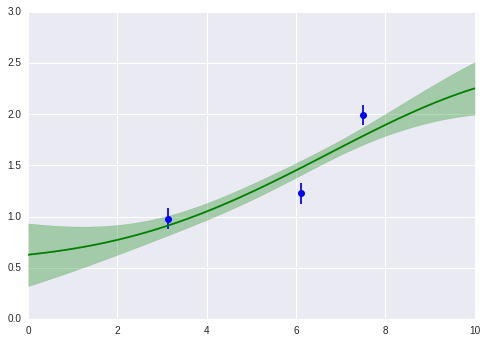

In [9]:
gp.recompute()

mu, cov = gp.predict(y+measurement_err,np.linspace(0,10,100) )
err = np.sqrt(np.diag(cov))

plt.errorbar(x,y+measurement_err,yerr = np.array([me for i in xrange(x.shape[0])]),fmt= 'o', color = 'b', label = 'Truth')

plt.plot(np.linspace(0,10,100), mu, color = 'g')
plt.fill_between(np.linspace(0,10,100), mu, mu+err, color = 'g', alpha = 0.3)
plt.fill_between(np.linspace(0,10,100), mu, mu-err, color = 'g', alpha = 0.3)

plt.show()